In [1]:
%%capture
"""
------------------------------------------------------------------------------------------------------------------------
Code used to perform the nested N-spheres experiment with NODEs and ANODEs. This was taken from Alex's GitHub:
https://github.com/a-norcliffe/sonode/blob/master/experiments/nested-n-spheres/nested-n-spheres_anode.py

It was then adapted to calculate the output in a slightly different way, by using cross entropy loss.
I have also made some small modifications that save the model at given iterations, which can then be used for
Hessian analysis.
------------------------------------------------------------------------------------------------------------------------
"""

In [2]:
%%capture
pip install torchdiffeq

In [99]:
import time
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False)
parser.add_argument('--visualise', type=eval, default=True)
parser.add_argument('--niters', type=int, default=600)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--extra_dim', type=int, default=1)
parser.add_argument('--data_dimension', type=int, default=2)
parser.add_argument('--npoints', type=int, default=50)
parser.add_argument('--ntest', type=int, default=10)
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.hessian_freq = 5
args.extra_dim = 0
args.visualise = True

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [69]:
class ODEfunc(nn.Module):
    """
    Neural network to parametrise the derivative of the state vector. Maps from [dim] to [dim] dimensions.
    """
    def __init__(self, dim, nhidden):
        super(ODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out
    

class ODEBlock(nn.Module):
    """
    Defines the entire ODE block that acts on the state vector, i.e. it perfoms integration on the state vector
    with the derivative given by an ODEFunc() object, and interval given by [t0, tN].
    """
    def __init__(self, odefunc, t0_, tN_):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_times = torch.tensor([t0_, tN_]).float()
        
    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_times, rtol=args.tol, atol=args.tol)
        out = out[1]
        return out

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [70]:
class Decoder(nn.Module):
    """
    Function that maps 2D output to another vector. 
    """
    def __init__(self, in_dim, out_dim):          #out_dim = 1.
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, z):
        out = self.fc(z)
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [100]:
if __name__ == '__main__':
    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
    if args.extra_dim == 0:
        filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/node/'
        models_filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/node/models/'
    else:
        filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/anode('+str(args.extra_dim)+')/'
        models_filename = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/anode('+str(args.extra_dim)+')/models/'
    try:
        os.makedirs(filename)
        
    except FileExistsError:
        pass

    try:
        os.makedirs(models_filename)
        
    except FileExistsError:
        pass

    dim = args.data_dimension + args.extra_dim
    
    #Download data
    name_in = str(args.data_dimension)+'din_'+str(args.npoints)+'_train.npy'        #Only use the training data.
    name_out = str(args.data_dimension)+'dout_'+str(args.npoints)+'_train.npy'
    folder_name = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/data/'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    target = torch.zeros([50])
    for i in range(len(zN)):
      if zN[i]==0:
        target[i] = 0
      else:
        target[i] = 1
    target = target.long()
    
    #Augment z0
    zeros = torch.zeros(args.npoints, args.extra_dim).float()
    z0 = torch.cat((z0, zeros), dim=1).to(device)

    # model
    t0, tN = 0, 1
    nhidden = 20
    feature_layers = [ODEBlock(ODEfunc(dim, nhidden), t0, tN), Decoder(dim, 2)]
    model = nn.Sequential(*feature_layers).to(device)         #the * bit means that only the elements of the list are taken.
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    loss_func = nn.CrossEntropyLoss()
    
    itr_arr = np.empty(args.niters)
    loss_arr = np.empty(args.niters)
    nfe_arr = np.empty(args.niters)
    time_arr = np.empty(args.niters)

    # training
    start_time = time.time()
    torch.save(model, models_filename + 'model_0.pt')
    for itr in range(1, args.niters + 1):
        feature_layers[0].nfe = 0
        iter_start_time = time.time()
        optimizer.zero_grad()

        # forward in time and solve ode
        pred_z = model(z0)
        # compute loss
        loss = loss_func(pred_z, target)
        loss.backward()
        optimizer.step()
        iter_end_time = time.time()
        #make arrays
        itr_arr[itr-1] = itr
        loss_arr[itr-1] = loss
        nfe_arr[itr-1] = feature_layers[0].nfe
        time_arr[itr-1] = iter_end_time-iter_start_time 

        if itr % args.hessian_freq == 0:
          torch.save(model, models_filename + 'model_' + str(itr) + '.pt')
        else:
          pass

        print('Iter: {}, running loss: {:.4f}'.format(itr, loss))
            

    end_time = time.time()
    print('\n')
    print('Training complete after {} iters.'.format(itr))
    print('Time = ' + str(end_time-start_time))
    loss = loss_func(pred_z, target).detach().numpy()
    print('Train Loss = ' +str(loss))
    print('NFE = ' +str(feature_layers[0].nfe))
    print('Parameters = '+str(count_parameters(model)))
    
    np.save(filename+'itr_arr.npy', itr_arr)
    np.save(filename+'nfe_arr.npy', nfe_arr)
    np.save(filename+'loss_arr.npy', loss_arr)
    np.save(filename+'time_arr.npy', time_arr)
    torch.save(model, filename+'model.pth')
    
    # make test data
    name_in = str(args.data_dimension)+'din_'+str(args.ntest)+'_test.npy'
    name_out = str(args.data_dimension)+'dout_'+str(args.ntest)+'_test.npy'
    folder_name = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/data/'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    target = torch.zeros([10])
    for i in range(len(zN)):
      if zN[i]==0:
        target[i] = 0
      else:
        target[i] = 1
    target = target.long()

    # augment z0
    zeros = torch.zeros(args.ntest, args.extra_dim).float()
    z0 = torch.cat((z0, zeros), dim=1).to(device)
    
    # run test data through network
    pred_z = model(z0)

    # compute loss
    loss = loss_func(pred_z, target).detach().numpy()
    print('Test Loss = ' +str(loss))
    
    if args.visualise:
        try:
            os.makedirs('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/figure_data/')
        except FileExistsError:
            pass
        #Generate a sequence of timepoints, such that the model can be evaluated at intermediate times during integration.   
        samp_ts = torch.linspace(t0, tN, 30)
        if args.data_dimension == 1:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/data'
                                      + '/vis_data/1d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name =  ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/figure_data'
                        + '/node_film_1d.npy')
            else:
                name =  ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0'
                        + '/figure_data/anode_film_(1+'+str(args.extra_dim)+')d.npy')
            np.save(name, pred_z)
        elif args.data_dimension == 2:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/data'
                                      + '/vis_data/2d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/figure_data'
                        + '/node_film_2d.npy')
            else:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/figure_data'
                        + '/anode_film_(2+'+str(args.extra_dim)+')d.npy')
            np.save(name, pred_z)
        elif args.data_dimension == 3:
            z0 = torch.tensor(np.load(  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/data'
                                      + '/vis_data./3d_vis_data.npy')).float()
            ntotal = len(z0)
            #Augment z0
            zeros = torch.zeros(ntotal, args.extra_dim).float()
            z0 = torch.cat((z0, zeros), dim=1).to(device)
            pred_z = odeint(feature_layers[0].odefunc, z0, samp_ts)
            pred_z = pred_z.detach().numpy()
            if args.extra_dim == 0:
                name = ('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/experiment_0/figure_data'
                        + '/node_film_3d.npy')
            else:
                pass
            np.save(name, pred_z)
        else:
            pass


Iter: 1, running loss: 0.6957
Iter: 2, running loss: 0.6922
Iter: 3, running loss: 0.6896
Iter: 4, running loss: 0.6873
Iter: 5, running loss: 0.6852
Iter: 6, running loss: 0.6830
Iter: 7, running loss: 0.6804
Iter: 8, running loss: 0.6772
Iter: 9, running loss: 0.6733
Iter: 10, running loss: 0.6683
Iter: 11, running loss: 0.6619
Iter: 12, running loss: 0.6540
Iter: 13, running loss: 0.6444
Iter: 14, running loss: 0.6330
Iter: 15, running loss: 0.6196
Iter: 16, running loss: 0.6041
Iter: 17, running loss: 0.5860
Iter: 18, running loss: 0.5659
Iter: 19, running loss: 0.5448
Iter: 20, running loss: 0.5237
Iter: 21, running loss: 0.5037
Iter: 22, running loss: 0.4853
Iter: 23, running loss: 0.4677
Iter: 24, running loss: 0.4469
Iter: 25, running loss: 0.4147
Iter: 26, running loss: 0.3872
Iter: 27, running loss: 0.3705
Iter: 28, running loss: 0.3279
Iter: 29, running loss: 0.2985
Iter: 30, running loss: 0.2793
Iter: 31, running loss: 0.2697
Iter: 32, running loss: 0.2644
Iter: 33, running

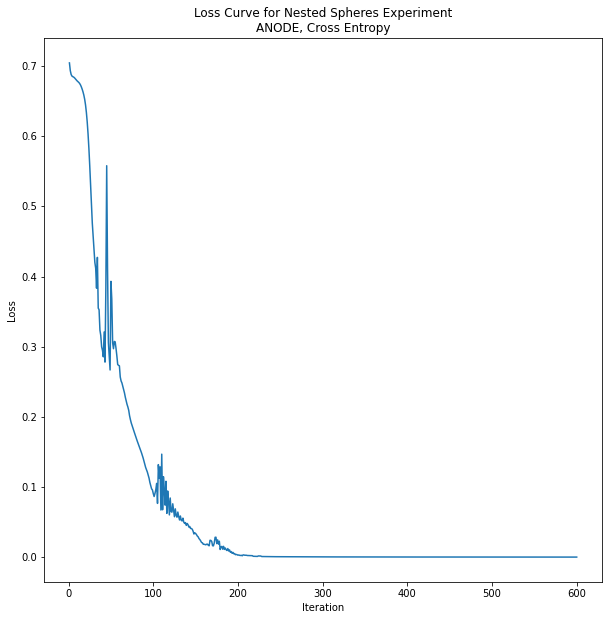

In [103]:
#Generate loss curve plot.
experiment_name = 'experiment_0'

loss_data = np.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' 
                    + experiment_name + '/anode(1)/loss_arr.npy')

iters = np.linspace(1,600,600)

plt.figure(figsize=[10,10])
plt.plot(iters, loss_data)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Nested Spheres Experiment\nANODE, Cross Entropy')
plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' 
                    + experiment_name + '/anode(1)/loss_curve.pdf')
plt.show()